<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_02/simple_example_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer perceptron - classifying digits from the MNIST dataset


Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter02_mathematical-building-blocks.ipynb  

MNIST dataset is a dataset of handwritten digits. It contains a training set of 60000 greyscale 28x28 images and a testing set of 10000 images of digits written by different people.

https://yann.lecun.com/exdb/mnist/
https://en.wikipedia.org/wiki/MNIST_database

## Load and preprocess the data

In [1]:
import keras

# Load the MNIST dataset
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# 1. Reshape and normalize the data:
# Reshape the data into a flat vector (784 elements) for input to our neural network.
# Convert the pixel values from integers [0-255] to floating-point numbers and normalize them to the range [0, 1].
x_train = train_images.reshape(60000, 28 * 28).astype('float32') / 255
x_test = test_images.reshape(10000, 28 * 28).astype('float32') / 255
y_train = train_labels
y_test = test_labels
print(x_train.shape, y_train.shape)


# 2. Arbitrary: one-hot encode the labels:
# For example, the label 3 would become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical  = keras.utils.to_categorical(y_test, num_classes=10)

print(y_train_categorical.shape)
print(y_train[:3])
print(y_train_categorical[:3])

# 3. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)



(60000, 784) (60000,)
(60000, 10)
[5 0 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Define and train the model

### MLP model for multiclass classification:
- 'softmax' activation function in the output layer 
- 'relu' or 'tanh' in the hidden layers
- Loss function and metrics based on label encoding:
    - If labels are one-hot vectors, use `CategoricalCrossentropy` as the loss function and `CategoricalAccuracy` as the metric.
    - If labels are provided as integers, use `SparseCategoricalCrossentropy` as the loss function and `SparseCategoricalAccuracy` as the metric.


In [2]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test Accuracy", "Test Loss"]
results_df = pd.DataFrame(columns=columns)

In [3]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "mnist_mlp_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_mnist/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(shape=(28 * 28,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp         
              loss= keras.losses.SparseCategoricalCrossentropy(),                
              metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")]) 

num_epochs = 8
batch_size = 64

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# Create a unique model name using the current date and time
model_name = model_dir + model_datetime_name + ".keras"
# Save the model with the generated name
model.save(model_name)

model_details = "512"

# Add results to the dataframe: 
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc, 
    "Test Loss" : test_loss, 
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_mlp_results.csv", index=False)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8839 - loss: 0.4056 - val_accuracy: 0.9612 - val_loss: 0.1264
Epoch 2/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9708 - loss: 0.1005 - val_accuracy: 0.9698 - val_loss: 0.0920
Epoch 3/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9828 - loss: 0.0601 - val_accuracy: 0.9775 - val_loss: 0.0763
Epoch 4/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9877 - loss: 0.0418 - val_accuracy: 0.9770 - val_loss: 0.0734
Epoch 5/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9909 - loss: 0.0286 - val_accuracy: 0.9770 - val_loss: 0.0748
Epoch 6/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9940 - loss: 0.0204 - val_accuracy: 0.9763 - val_loss: 0.0822
Epoch 7/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9945 - loss: 0.0174 - val_accuracy: 0.9780 - val_loss: 0.0719
Epoch 8/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0

C:\Users\zuzka\AppData\Local\Temp\ipykernel_84172\1749362233.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


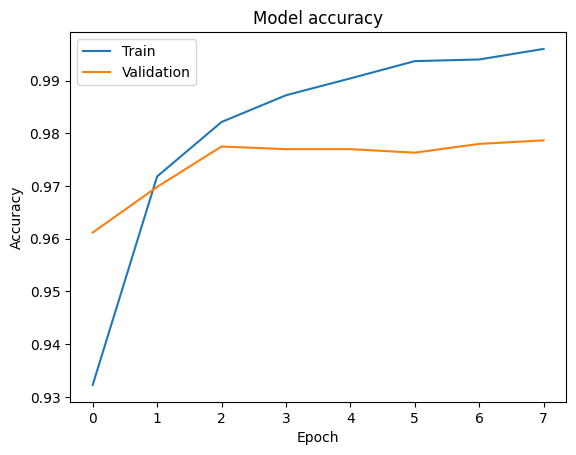

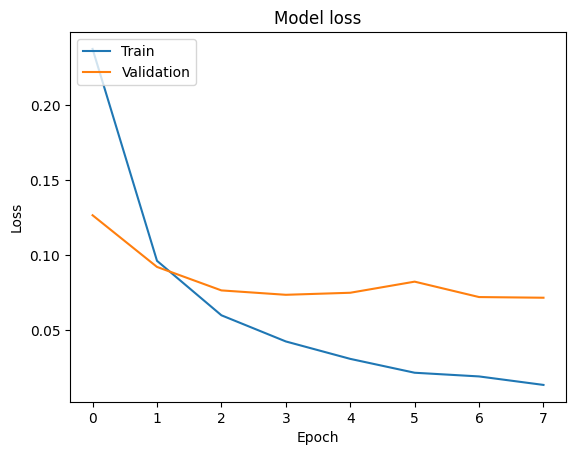

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9969 - loss: 0.0117
Training accuracy: 0.9972222447395325 
Train loss: 0.010885119438171387
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.0765
Validation accuracy: 0.9786666631698608 
Val loss: 0.07145233452320099
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9773 - loss: 0.0841
Test accuracy: 0.9811000227928162 
Test loss: 0.06978443264961243


In [4]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[1.32743386e-10 6.62693234e-11 1.11822205e-08 2.71699570e-08
 1.10427069e-13 7.70603859e-10 6.30021539e-15 1.00000000e+00
 3.82539111e-09 2.07562145e-08]
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
True labels: [7 2 1 0 4 1 4 9 5 9]
Number of misclassified images: 189 out of 10000 , accuracy 0.9811000227928162


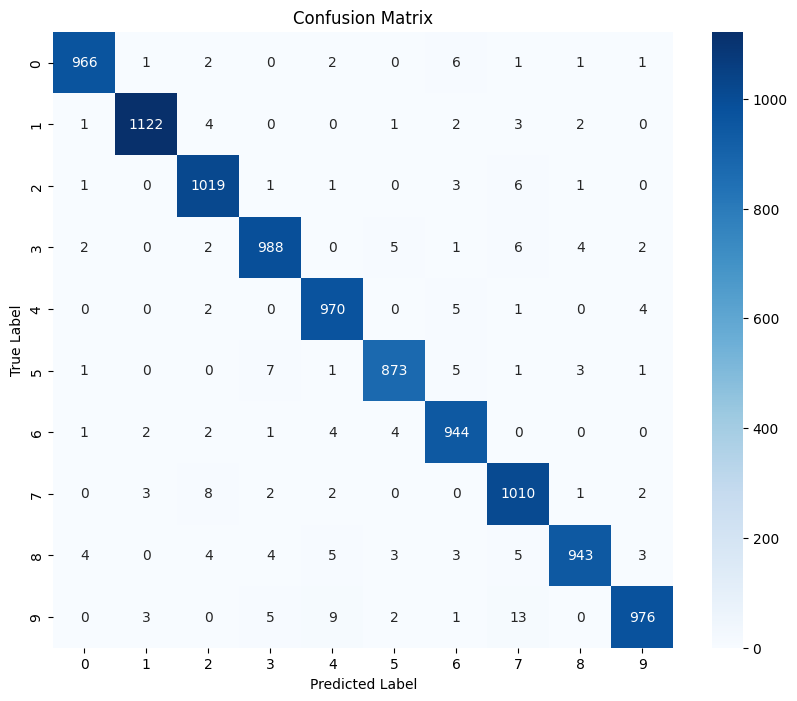

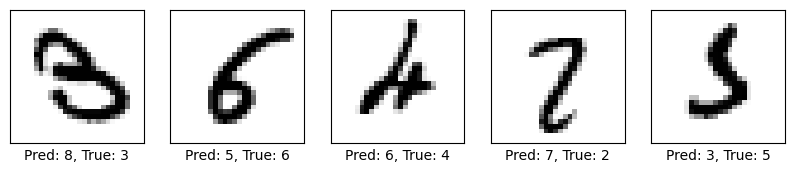

In [6]:
import numpy as np
# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)
print(y_pred_probs[0])

# Get the predicted class for each sample
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predicted labels:", y_pred[:10])
print("True labels:", y_test[:10])

# Misclassified indices:
misclassified_indices = np.where(y_pred != y_test)[0]
num_misclassified = len(misclassified_indices)
print("Number of misclassified images:", num_misclassified, 
      "out of", len(y_test), ", accuracy", test_acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot some misclassified images
num_images_to_plot = 5
plt.figure(figsize=(10, 10))
for i in range(min(num_images_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {y_pred[index]}, True: {y_test[index]}")
plt.show()

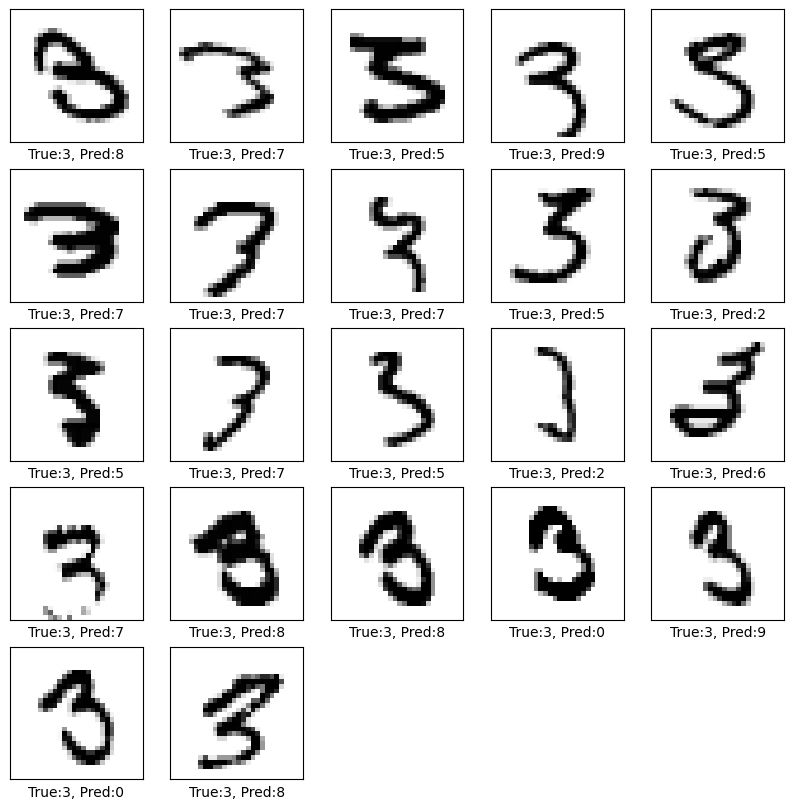

In [7]:
# Plot some misclassified images from a given target (or predicted) class
target_class = 3
misclassified_indices_class = np.where((y_pred != y_test) & (y_test == target_class))[0]
#misclassified_indices_class = np.where((y_pred != y_test) & (y_pred == target_class))[0]



# Display the first 25 misclassified images for the target class
plt.figure(figsize=(10, 10))
for i in range(min(25, len(misclassified_indices_class))):
    index = misclassified_indices_class[i]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"True:{y_test[index]}, Pred:{y_pred[index]}")
plt.show()


In [8]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_mnist --reload_interval=1

Reusing TensorBoard on port 6006 (pid 4864), started 6 days, 13:30:01 ago. (Use '!kill 4864' to kill it.)